# 11. Variational Auto-Encoder

_Exercise: Train a variational autoencoder on the image dataset of your choice, and use it to generate images. Alternatively, you can try to find an unlabeled dataset that you are interested in and see if you can generate new samples._

## Prepare environment

In [102]:
import tensorflow as tf

from keras import (
    layers,
    datasets,
    metrics,
    optimizers,
    callbacks,
    Model,
    losses,
    Sequential
)

import numpy as np

from matplotlib import pyplot as plt

from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score

from skimage.metrics import structural_similarity

from collections import Counter

np.random.seed(42)
tf.random.set_seed(42)

### Hyperparameters

In [2]:
EPOCHS = 25
EARLY_STOPPING_PATIENCE = 5
BATCH_SIZE = 128
LATENT_DIM = 10
KL_WEIGHT = 1.0
LEARNING_RATE = 1e-3
OPTIMIZER = optimizers.Nadam(learning_rate=LEARNING_RATE)

I0000 00:00:1744275376.831632    7441 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2874 MB memory:  -> device: 0, name: Quadro P600, pci bus id: 0000:01:00.0, compute capability: 6.1


## Prepare dataset

In [3]:
(x_train, y_train), (x_test, y_test) = datasets.mnist.load_data()
x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255

In [103]:
Counter(y_train)

Counter({1: 6742,
         7: 6265,
         3: 6131,
         2: 5958,
         9: 5949,
         0: 5923,
         6: 5918,
         8: 5851,
         4: 5842,
         5: 5421})

## Train Variational Auto-Encoder

In [4]:
class Sampling(layers.Layer):
    def call(self, inputs):
        mean, log_var = inputs
        return tf.random.normal(tf.shape(log_var)) * tf.exp(log_var / 2) + mean 

### Encoder

In [5]:
inputs = layers.Input(shape=(28, 28))
Z = layers.Flatten()(inputs)
Z = layers.Dense(150, activation="relu")(Z)
Z = layers.Dense(100, activation="relu")(Z)
codings_mean = layers.Dense(LATENT_DIM)(Z)  # μ
codings_log_var = layers.Dense(LATENT_DIM)(Z)  # γ
codings = Sampling()([codings_mean, codings_log_var])
variational_encoder = Model(
    inputs=inputs, outputs=[codings_mean, codings_log_var, codings])

### Decoder

In [6]:
decoder_inputs = layers.Input(shape=[LATENT_DIM])
x = layers.Dense(100, activation="relu")(decoder_inputs)
x = layers.Dense(150, activation="relu")(x)
x = layers.Dense(28 * 28)(x)
outputs = layers.Reshape((28, 28))(x)
variational_decoder = Model(inputs=decoder_inputs, outputs=outputs)

### Loss layer

In [7]:
class VAELossLayer(layers.Layer):
    def __init__(self, beta, **kwargs):
        super(VAELossLayer, self).__init__(**kwargs)
        self.beta = beta
        self.reconstruction_loss_tracker = metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = metrics.Mean(name="kl_loss")
        self.total_loss_tracker = metrics.Mean(name="total_loss")

    @property
    def metrics(self):
        return [
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
            self.total_loss_tracker,
        ]

    def call(self, inputs, codings_mean, codings_log_var, reconstructions):
        # 1. Reconstruction Loss
        reconstruction_loss = tf.reduce_mean(
            losses.binary_crossentropy(inputs, reconstructions)
        )
        reconstruction_loss *= tf.cast(tf.reduce_prod(inputs.shape[1:]), tf.float32) # Scale for pixel-wise loss

        # 2. KL Divergence Loss
        kl_loss = -0.5 * tf.reduce_sum(
            1 + codings_log_var - tf.square(codings_mean) - tf.exp(codings_log_var),
            axis=-1
        )
        kl_loss = tf.reduce_mean(kl_loss)  # Average over the batch

        # 3. Total VAE Loss
        total_loss = reconstruction_loss + self.beta * kl_loss

        # Add the total loss to the model
        self.add_loss(total_loss)

        # Add loss values to metrics for monitoring
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        self.total_loss_tracker.update_state(total_loss)

        return reconstructions

### Variational Auto-Encoder

In [8]:
codings_mean, codings_log_var, codings = variational_encoder(inputs)
reconstructions = variational_decoder(codings)
outputs = VAELossLayer(beta=KL_WEIGHT)(inputs, codings_mean, codings_log_var, reconstructions)
variational_ae = Model(inputs=inputs, outputs=outputs)

### Compilation and training

In [9]:
early_stopping_cb = callbacks.EarlyStopping(
    patience=EARLY_STOPPING_PATIENCE, restore_best_weights=True, mode="min"
)

variational_ae.compile(optimizer=OPTIMIZER)
history = variational_ae.fit(
    x_train, x_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=(x_test, x_test), callbacks=[early_stopping_cb]
)

Epoch 1/25


I0000 00:00:1744275382.126954   12249 service.cc:148] XLA service 0x7ff35c0121f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1744275382.127555   12249 service.cc:156]   StreamExecutor device (0): Quadro P600, Compute Capability 6.1
2025-04-10 10:56:22.214085: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1744275382.468076   12249 cuda_dnn.cc:529] Loaded cuDNN version 90700


 28/469 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - kl_loss: 2.1335 - loss: 694.0745 - reconstruction_loss: 691.9410 - total_loss: 694.0745

I0000 00:00:1744275386.168531   12249 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


469/469 ━━━━━━━━━━━━━━━━━━━━ 16s 19ms/step - kl_loss: 7.8871 - loss: 302.2245 - reconstruction_loss: 294.3372 - total_loss: 302.2244 - val_kl_loss: 12.5886 - val_loss: 203.1239 - val_reconstruction_loss: 190.5533 - val_total_loss: 203.1419
Epoch 2/25
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - kl_loss: 13.1689 - loss: 201.7796 - reconstruction_loss: 188.6107 - total_loss: 201.7795 - val_kl_loss: 14.0973 - val_loss: 191.4754 - val_reconstruction_loss: 177.3649 - val_total_loss: 191.4622
Epoch 3/25
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - kl_loss: 14.7622 - loss: 199.3215 - reconstruction_loss: 184.5592 - total_loss: 199.3214 - val_kl_loss: 15.8868 - val_loss: 185.2683 - val_reconstruction_loss: 169.3842 - val_total_loss: 185.2710
Epoch 4/25
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - kl_loss: 15.1220 - loss: 189.2300 - reconstruction_loss: 174.1081 - total_loss: 189.2300 - val_kl_loss: 13.9720 - val_loss: 208.1980 - val_reconstruction_loss: 194.2471 - val_total_loss: 208.2191
Epoch 5/25

## Evaluation

### Learning curves

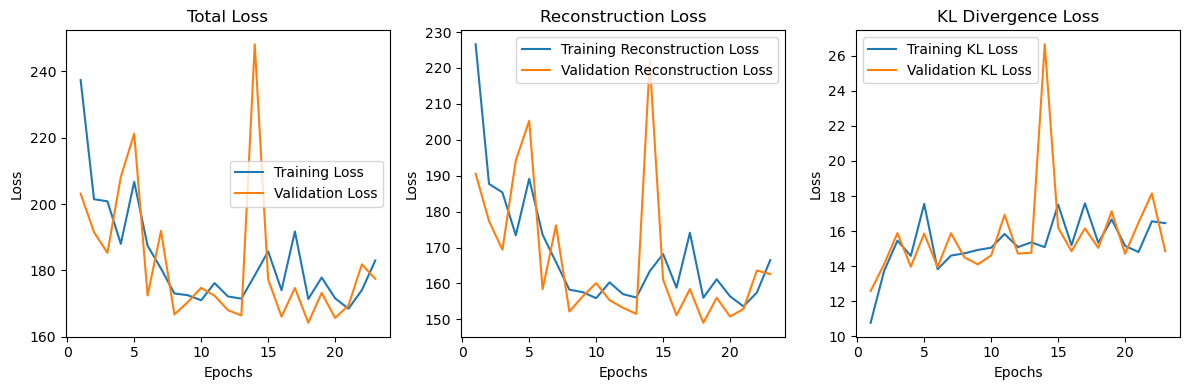

In [10]:
# Plotting the losses after training
total_loss = history.history['loss']
reconstruction_loss = history.history['reconstruction_loss']
kl_loss = history.history['kl_loss']
val_loss = history.history.get('val_loss')
val_reconstruction_loss = history.history.get('val_reconstruction_loss')
val_kl_loss = history.history.get('val_kl_loss')

epochs_range = range(1, len(total_loss) + 1)

plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.plot(epochs_range, total_loss, label='Training Loss')
if val_loss:
    plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.title('Total Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(epochs_range, reconstruction_loss, label='Training Reconstruction Loss')
if val_reconstruction_loss:
    plt.plot(epochs_range, val_reconstruction_loss, label='Validation Reconstruction Loss')
plt.title('Reconstruction Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(epochs_range, kl_loss, label='Training KL Loss')
if val_kl_loss:
    plt.plot(epochs_range, val_kl_loss, label='Validation KL Loss')
plt.title('KL Divergence Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

### Reconstructions

In [25]:
print("\nEvaluating Reconstruction Quality...")
reconstructed_sample = variational_ae.predict(x_test)

# Calculate Reconstruction Error (Proxy for visual quality)
reconstruction_mse = np.mean((x_test - reconstructed_sample)**2)
print(f"Mean Squared Error (MSE) on {len(x_test)} test samples: {reconstruction_mse:.6f}")
# Lower MSE generally means better reconstruction fidelity.


Evaluating Reconstruction Quality...
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Mean Squared Error (MSE) on 10000 test samples: 0.125526


In [68]:
# Train a very basic classifier on real MNIST data
def build_simple_classifier():
    model = Sequential([
        layers.Input(shape=(28, 28)),
        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        layers.Dense(10, activation='softmax') # 10 classes for MNIST digits
    ])
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

classifier = build_simple_classifier()
# Train on a subset (with more data accuracy/confidence is high even for not that clear images)
classifier.fit(x_train[:10000], y_train[:10000], epochs=5, batch_size=128, verbose=0)

In [123]:
predictions = classifier.predict(reconstructed_sample)
true_confidence = [pred[y] for pred, y in zip(predictions, y_test)]
mean_true_confidence = np.mean(true_confidence)
print(f"Mean confidence of true labels on reconstructed images: {mean_true_confidence}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Mean confidence of true labels on reconstructed images: 0.5008351802825928


In [53]:
print("\nEvaluating the structural similarity index measure (SSIM)...")

ssim_scores = []
for i in range(len(x_test)):
    ssim = structural_similarity(x_test[i], reconstructed_sample[i], data_range=1)
    ssim_scores.append(ssim)
mean_ssim = np.mean(ssim_scores)
print(f"The mean structural similarity index measure (SSIM) on {len(x_test)} test samples: {mean_ssim}")


Evaluating the structural similarity index measure (SSIM)...
The mean structural similarity index measure (SSIM) on 10000 test samples: 0.2085349718482464


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


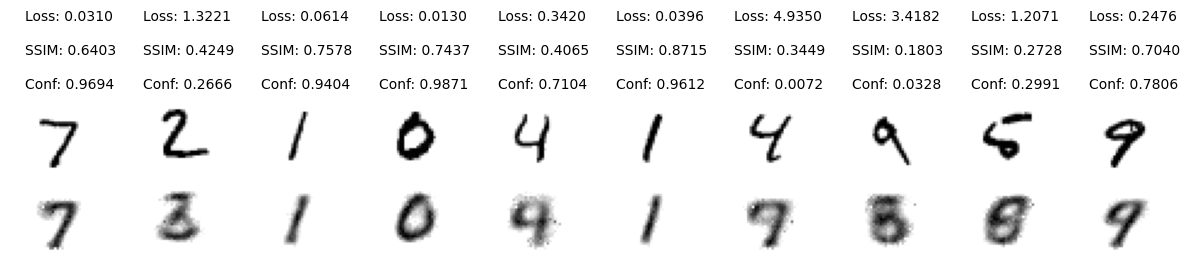

In [101]:
def plot_reconstructions(model, images, labels, n_images=10):
    reconstructions = np.clip(model.predict(images[:n_images]), 0, 1)
    fig = plt.figure(figsize=(n_images * 1.5, 3))
    for image_index in range(n_images):

        plt.subplot(3, n_images, 1 + image_index)
        sample_prediction = classifier.predict(np.expand_dims(reconstructions[image_index], axis=0))
        sample_confidence = sample_prediction[0][labels[image_index]]
        plt.text(0.15, 0, "Conf: {:.4f}".format(sample_confidence))

        sample_ssmi = structural_similarity(images[image_index], reconstructions[image_index], data_range=1)
        plt.text(0.15, 0.5, "SSIM: {:.4f}".format(sample_ssmi))

        sample_loss, _ = classifier.evaluate(
            np.expand_dims(reconstructions[image_index], axis=0),
            np.expand_dims(labels[image_index], axis=0),
            verbose=0
        )
        plt.text(0.15, 1.0, "Loss: {:.4f}".format(sample_loss))
        plt.axis("off")

        plt.subplot(3, n_images, 1 + n_images + image_index)
        plt.imshow(images[image_index], cmap="binary")
        plt.axis("off")

        plt.subplot(3, n_images, 1 + 2 * n_images + image_index)
        plt.imshow(reconstructions[image_index], cmap="binary")
        plt.axis("off")

plot_reconstructions(variational_ae, images=x_test, labels=y_test)
plt.show()

### Image Generation

In [12]:
codings = tf.random.normal(shape=[3 * 7, LATENT_DIM])
images = variational_decoder(codings).numpy()

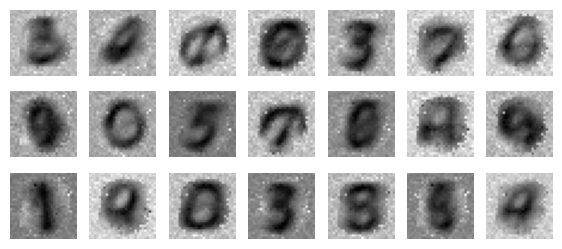

In [13]:
def plot_multiple_images(images, n_cols=None):
    n_cols = n_cols or len(images)
    n_rows = (len(images) - 1) // n_cols + 1
    if images.shape[-1] == 1:
        images = images.squeeze(axis=-1)
    plt.figure(figsize=(n_cols, n_rows))
    for index, image in enumerate(images):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(image, cmap="binary")
        plt.axis("off")

plot_multiple_images(images, 7)
plt.show()

### Latent space exploration

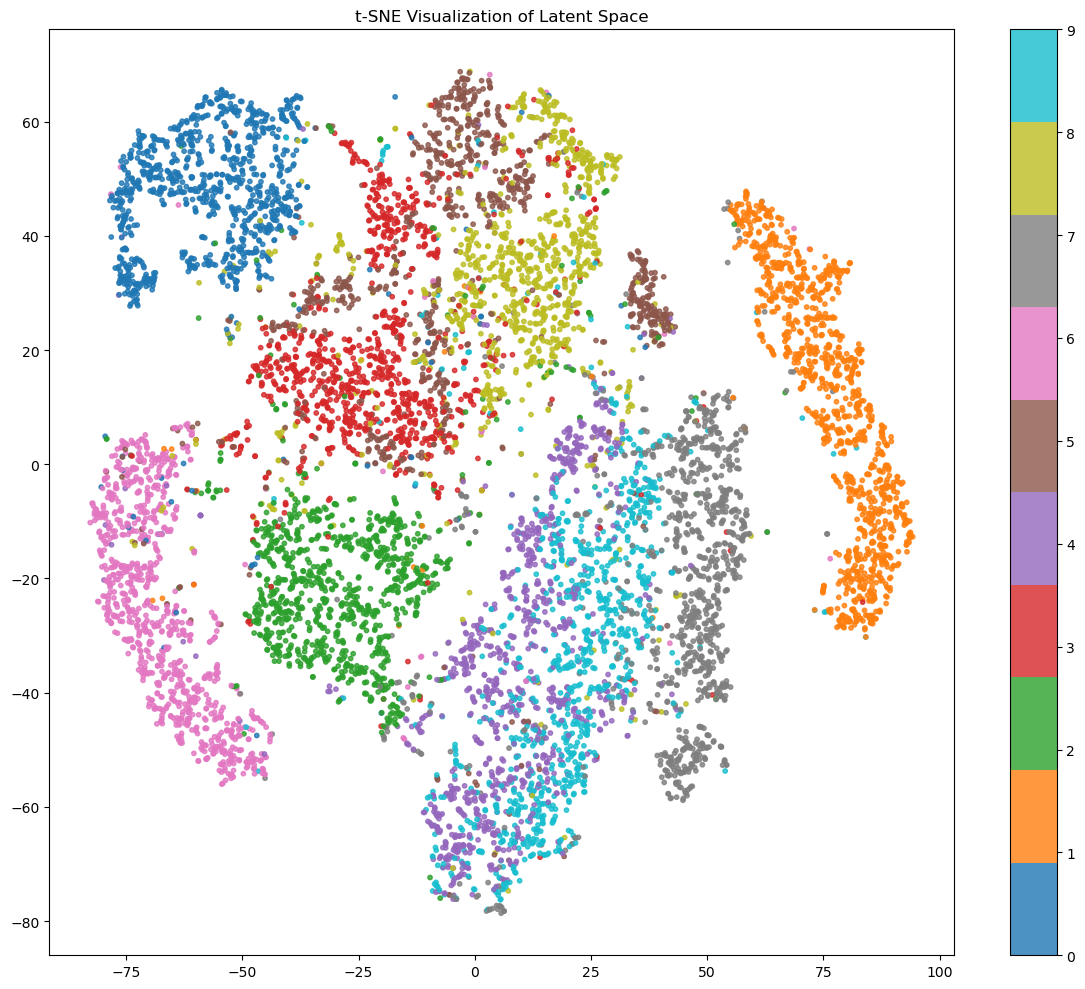

In [ ]:
samples = x_test
labels = y_test

# Encode to latent space
codings_mean, codings_log_var, codings = variational_encoder(samples)

# Dimensionality reduction with t-SNE
tsne = TSNE(n_components=2, perplexity=30, learning_rate=200)
z_tsne = tsne.fit_transform(codings_mean)

# Plot
plt.figure(figsize=(12, 10))
scatter = plt.scatter(z_tsne[:, 0], z_tsne[:, 1], c=labels,
            cmap='tab10', s=10, alpha=0.8)
plt.colorbar(scatter, ticks=range(10))
plt.title("t-SNE Visualization of Latent Space")
plt.tight_layout()
plt.show()

### Average Variances per Latent Dimension

In [15]:
variances = np.exp(codings_log_var.numpy())

average_variances = np.mean(variances, axis=0)

print("Average Variances per Latent Dimension:")
for i, avg_var in enumerate(average_variances):
    print(f"Dimension {i}: {avg_var:.4f}")

Average Variances per Latent Dimension:
Dimension 0: 0.0579
Dimension 1: 0.0916
Dimension 2: 0.0749
Dimension 3: 0.0442
Dimension 4: 0.1037
Dimension 5: 0.0378
Dimension 6: 0.0958
Dimension 7: 0.0757
Dimension 8: 0.2322
Dimension 9: 0.1114


In [16]:
threshold = 1e-3  # Adjust this threshold as needed
unused_dimensions = np.where(average_variances < threshold)[0]
print(f"\nPotentially Unused Dimensions (below threshold {threshold}): {unused_dimensions}")


Potentially Unused Dimensions (below threshold 0.001): []


### Adjusted Rand Index

In [17]:
# Perform clustering on the latent space
n_clusters = len(np.unique(y_test))  # Assuming the number of clusters equals the number of classes
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(codings_mean)

# Compute the ARI
ari_score = adjusted_rand_score(labels, cluster_labels)
print(f"Adjusted Rand Index (ARI): {ari_score}")

Adjusted Rand Index (ARI): 0.43028608685719943


### Semantic interpolation between 2 images

In [18]:
codings = np.zeros([7, LATENT_DIM])
codings[:, 9] = np.linspace(-0.8, 0.8, 7) 
images = variational_decoder(codings).numpy()

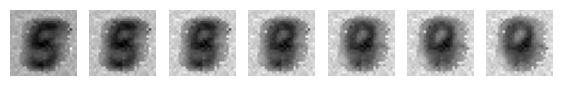

In [19]:
plot_multiple_images(images)
plt.show()

### Evaluate based on Simple Classifier

In [ ]:
# Evaluate classifier on REAL test data (as a baseline)
_, real_accuracy = classifier.evaluate(x_test, y_test, verbose=0)
print(f"Simple classifier accuracy on REAL test data: {real_accuracy:.4f}")

# Generate a large batch of images
n_generated_for_eval = 5000
random_latent_vectors_eval = np.random.normal(size=(n_generated_for_eval, LATENT_DIM))
generated_images_eval = variational_decoder.predict(random_latent_vectors_eval)

# Predict labels for generated images
generated_predictions = classifier.predict(generated_images_eval)
generated_labels = np.argmax(generated_predictions, axis=1)
generated_confidence = np.mean(np.max(generated_predictions, axis=1))

# Score: Average confidence of the classifier on generated images.
# Higher confidence suggests the classifier "recognizes" the generated images better.
print(f"Average classifier confidence on {n_generated_for_eval} GENERATED images: {generated_confidence:.4f}")

Simple classifier accuracy on REAL test data: 0.9227
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Average classifier confidence on 5000 GENERATED images: 0.7195
Distribution of predicted labels for generated images:
{0: 578, 1: 812, 2: 86, 3: 27, 4: 1954, 5: 3, 6: 124, 7: 57, 8: 969, 9: 390}

Combined Performance Score (Heuristic): 0.0531
(Higher is generally better, combines low reconstruction error and high generation confidence)


### Distribution of predicted labels for generated images

In [104]:
# A good generator should produce all digits somewhat evenly.
print("Distribution of predicted labels for generated images:")
print(dict(zip(np.histogram(generated_labels, bins=np.arange(11))[1], np.histogram(generated_labels, bins=np.arange(11))[0])))

Distribution of predicted labels for generated images:
{0: 578, 1: 812, 2: 86, 3: 27, 4: 1954, 5: 3, 6: 124, 7: 57, 8: 969, 9: 390}
